In [1]:
import tensorflow as tf
import requests
%pylab inline
import numpy as np
import pickle

C:\Users\T480\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


In [2]:
#This is an implementation of the Reservoir used for Reservoir Computing

# from https://github.com/m-colombo/Tensorflow-EchoStateNetwork/blob/master/esn_cell.py

from tensorflow.python.ops import rnn_cell_impl
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.framework.ops import convert_to_tensor


class ESNCell(rnn_cell_impl.RNNCell):
    """Echo State Network Cell.

    Based on http://www.faculty.jacobs-university.de/hjaeger/pubs/EchoStatesTechRep.pdf
    Only the reservoir, the randomized recurrent layer, is modelled. The readout trainable layer
    which map reservoir output to the target output is not implemented by this cell,
    thus neither are feedback from readout to the reservoir (a quite common technique).

    Here a practical guide to use Echo State Networks:
    http://minds.jacobs-university.de/sites/default/files/uploads/papers/PracticalESN.pdf

    Since at the moment TF doesn't provide a way to compute spectral radius
    of a matrix the echo state property necessary condition `max(eig(W)) < 1` is approximated
    scaling the norm 2 of the reservoir matrix which is an upper bound of the spectral radius.
    See https://en.wikipedia.org/wiki/Matrix_norm, the section on induced norms."""
    
    def __init__(self, num_units, wr2_scale=0.7, connectivity=0.1, leaky=1.0, activation=math_ops.tanh,
               win_init=init_ops.random_normal_initializer(),
               wr_init=init_ops.random_normal_initializer(),
               bias_init=init_ops.random_normal_initializer()):
        """Initialize the Echo State Network Cell.

        Args:
          num_units: Int or 0-D Int Tensor, the number of units in the reservoir
          wr2_scale: desired norm2 of reservoir weight matrix.
            `wr2_scale < 1` is a sufficient condition for echo state property.
          connectivity: connection probability between two reservoir units
          leaky: leaky parameter
          activation: activation function
          win_init: initializer for input weights
          wr_init: used to initialize reservoir weights before applying connectivity mask and scaling
          bias_init: initializer for biases
        """
        self._num_units = num_units
        self._leaky = leaky
        self._activation = activation
        
        def _wr_initializer(shape, dtype, partition_info=None):
            wr = wr_init(shape, dtype=dtype)

            connectivity_mask = math_ops.cast(
                  math_ops.less_equal(
                    random_ops.random_uniform(shape),
                    connectivity),
                dtype)

            wr = math_ops.multiply(wr, connectivity_mask)

            wr_norm2 = math_ops.sqrt(math_ops.reduce_sum(math_ops.square(wr)))

            is_norm_0 = math_ops.cast(math_ops.equal(wr_norm2, 0), dtype)

            wr = wr * wr2_scale / (wr_norm2 + 1 * is_norm_0)

            return wr
    
        self._win_initializer = win_init
        self._bias_initializer = bias_init
        self._wr_initializer = _wr_initializer
        
    

    

    @property
    def output_size(self):
        return self._num_units

    @property
    def state_size(self):
        return self._num_units

    def __call__(self, inputs, state, scope=None):
        
        """ Run one step of ESN Cell

            Args:
              inputs: `2-D Tensor` with shape `[batch_size x input_size]`.
              state: `2-D Tensor` with shape `[batch_size x self.state_size]`.
              scope: VariableScope for the created subgraph; defaults to class `ESNCell`.

            Returns:
              A tuple `(output, new_state)`, computed as
              `output = new_state = (1 - leaky) * state + leaky * activation(Win * input + Wr * state + B)`.

            Raises:
              ValueError: if `inputs` or `state` tensor size mismatch the previously provided dimension.
        """

        inputs = convert_to_tensor(inputs)
        input_size = inputs.get_shape().as_list()[1]
        dtype = inputs.dtype

        with vs.variable_scope(scope or type(self).__name__, reuse = tf.AUTO_REUSE):  # "ESNCell"
            
            win = vs.get_variable("InputMatrix", [input_size, self._num_units], dtype=dtype,
                            trainable=False, initializer=self._win_initializer)
            wr = vs.get_variable("ReservoirMatrix", [self._num_units, self._num_units], dtype=dtype,
                           trainable=False, initializer=self._wr_initializer)
            b = vs.get_variable("Bias", [self._num_units], dtype=dtype, trainable=False, initializer=self._bias_initializer)

            in_mat = array_ops.concat([inputs, state], axis=1)
            weights_mat = array_ops.concat([win, wr], axis=0)

            output = (1 - self._leaky) * state + self._leaky * self._activation(math_ops.matmul(in_mat, weights_mat) + b)

        return output, output


In [3]:
# This reads a txt file and does whitening on the data
def get_data(filename):
    #get the data, this should be replaced by an interface with the actual database
    with open (filename) as f:
        txt_data = [x.split(';') for x in f.readlines()]
        tt = [x[3].strip() for x in txt_data[1:]]
        rf = [x[4].strip() for x in txt_data[1:]]
        raw_data = np.array((tt,rf),dtype=float).T
        
        #scale the data to 0:1
        data_max = np.amax(raw_data,axis=0)
        scaled_data = raw_data / data_max
        #whiten the data
        data_mean = np.mean(scaled_data,axis = 0)
        data_std = np.std(scaled_data, axis = 0)
        white_data = (scaled_data - data_mean ) / data_std
        return [white_data, scaled_data, raw_data], [data_max, data_mean, data_std]

In [4]:
# this allows to break the time series into sequences of a given length (currently unused)
def break_sequence(data,lookback = 25):
    #data assumed to be shape (variables,timesteps)
    n = data.shape[1]
    windows = [data[:,i - lookback : i] for i in np.arange(lookback,n)]
    sequence = np.stack(windows,axis = 1)
    return sequence

In [5]:
#this trains an echo state network on a data set
def rc_train(train,state_size, con, wr2, l):
    tf.reset_default_graph()
    #generate a reservoir
    esn =  ESNCell(state_size,connectivity = con, wr2_scale = wr2, leaky = l)
    n = train.shape[2]
    #train it
    with tf.Session() as training:
        outputs, states = tf.nn.dynamic_rnn(esn,train.T,dtype = tf.float64)
        #run
        training.run(tf.global_variables_initializer())
        val = outputs.eval(session=training)
        #train the readout
        beta = 0.1 #regularization parameter of the ridge regression
        t = train[:,:,1:].reshape(1,n-1) #targets
        u = train[:,:,:-1].reshape(n-1,1) #inputs
        x = val[:-1,:,:].reshape(n-1,state_size) #reservoir outputs
        b = np.ones((n-1,1)) #biases
        design_mat = np.append(np.append(b,u,axis=1),x,axis=1)
        w_out = t @( design_mat.T @ np.linalg.inv(design_mat @ design_mat.T - beta * np.eye(n-1))).T #ride regression formula
    return w_out,esn

#this generates predictions from a trained reservoir and a timeseries
def rc_test(test,w_out,esn):
    tf.reset_default_graph()
    m = test.shape[2]
    with tf.Session() as testing:
        #run the reservoir
        out_test, states_test = tf.nn.dynamic_rnn(esn, test.T,dtype = tf.float64)
        testing.run(tf.global_variables_initializer())
        x = out_test.eval(session = testing).reshape(m, esn.state_size)
        bias = np.ones((m,1))
        u = test.reshape(m,1)
        design_test = np.append(np.append(bias,u,axis=1),x,axis=1)
        y = w_out @ design_test.T #calculate predictions from design matrix and weights
    return y

#given a timeseries this will generate 'future' further predictions into the future for each point in the timeseries
def rc_mult_test(test,w_out,esn,future):
    m = test.shape[2]
    predictions = np.zeros((m,future))
    #for each point in the test-series this will calculate a prediction of the next time-step,
    #then this prediction will be used as new input for 'future' steps
    #then the next time point will be taken from the test-series again
    for i in range(m):
        for f in range(future):
            if f == 0:
                predictions[i,f] = rc_test(test[:,:,i].reshape(1,1,1),w_out,esn)
            else:
                predictions[i,f] = rc_test(predictions[i,f-1].reshape(1,1,1),w_out,esn)
    return predictions


In [6]:
variable = []
#get the (pre-processed) data
filename = 'temperature_toy.txt' #this is one set of hourly temperature data taken from the dwd website
preproc = True
data_list, stat_list = get_data(filename)

if preproc:
    data = data_list[0].T
else:
    data = data_list[2].T

#n is the length of the training sequence
#m is the length of the test sequence
m = 300
n = data.shape[1] - m
#get training set
train = data[0,:-m].reshape(1,1,n)
#get test set
test = data[0,-m:].reshape(1,1,m)


In [7]:
#this performs cross-validation over a set of parameter values to try
def cross_val_rc(l_set,cn_set,wr_set,state_size):
    avg_mse = np.zeros((len(l_set),len(cn_set),len(wr_set)))
    for idx1,l in enumerate(l_set):
        for idx2,c in enumerate(cn_set):
            for idx3,w in enumerate(wr_set):
                w_out, y = reservoir_computing(train, test, state_size, c, w, l)
                avg_mse[idx1,idx2,idx3] = np.sum((y - test[:,:,1:].flatten())**2)
    return avg_mse

In [8]:
#this trains and generates predictions

state_size = 1000 #arbitrarily chosen
future = 6 

cross_val = False
if cross_val:
    l_set = [0.1, 0.3, 0.5 , 0.7, 0.9]
    cn_set = [0.01, 0.1, 0.2]
    wr_set = [0.3, 0.5, 0.7, 0.9]
    avg_mse = cross_val_rc(l_set,cn_set,wr_set,state_size)
    best_idx = np.argmin(avg_mse)
    best_params = np.unravel_index(best_idx,((len(l_set),len(cn_set),len(wr_set))))
    l = l_set(best_params[0])
    c = cn_set(best_params[1])
    w = wr_set(best_params[2])
else:
    #these were the results of a previous cv run
    c = 0.1
    w = 0.5
    l = 0.3

w_out,esn = rc_train(train, state_size,c,w,l)
y = rc_test(test,w_out,esn)
y_mult = rc_mult_test(test,w_out,esn, future)

In [9]:
#this calculates the mean squared error between the prediction and the actual data
mse = np.sum((y[:,:-1] - test[:,:,1:].flatten())**2)
#this calculates the mse between the data and a "model" that simply predicts the same value as the last step
mse_ref = np.sum((test[:,:,:-1].flatten() - test[:,:,1:].flatten())**2)
print('mse_pred: %s' %mse)
print('mse_ref: %s' %mse_ref)

mse_pred: 3.7553394074105615
mse_ref: 0.4098524172270809


In [10]:
#this transforms the model output to degree celsius scale

if preproc:
    y_cels = ((y * stat_list[2][0]) + stat_list[1][0])  * stat_list[0][0]
else:
    y_cels = y
data_cels = data_list[2].T



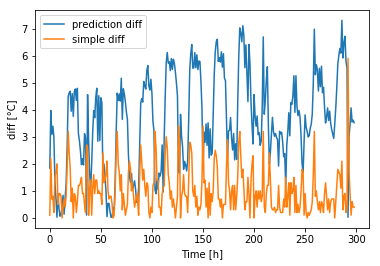

In [11]:
time = range(m-1)
plot(time, np.abs(y_cels.flatten()[:-1] - data_cels[0,-m+1:].flatten()),label = 'prediction diff')
plot(time, np.abs(data_cels[0,-m+1:].flatten() - data_cels[0,-m:-1].flatten()), label = 'simple diff')
legend()
ylabel('diff [°C]')
xlabel('Time [h]')
show()

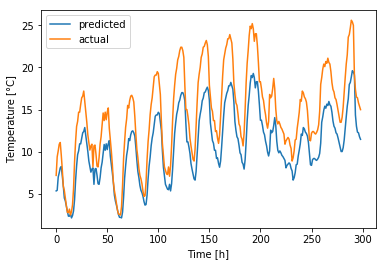

In [12]:
time = range(m-1)
plot(time, y_cels.flatten()[:-1],label = 'predicted')
plot(time, data_cels[0,-m+1:], label = 'actual')
legend()
ylabel('Temperature [°C]')
xlabel('Time [h]')
show()

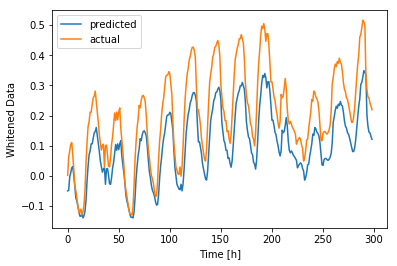

In [13]:
time = range(m-1)
plot(time, y.flatten()[:-1],label = 'predicted')
plot(time, test[:,:,1:].flatten(), label = 'actual')
legend()
ylabel('Whitened Data')
xlabel('Time [h]')
show()